In [18]:
import time

In [19]:
import torch 
import torchvision
import torchvision.models as models
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.init as init
import torch.nn.functional as F

cuda_available = torch.cuda.is_available()
device = torch.device("cuda:0" if cuda_available else "cpu")
print(f'''using device {device}''')

import matplotlib.pyplot as plt
import numpy as np

using device cuda:0


In [20]:
path = !pwd
path = path[0]
print(path)

/home/ola/Documents/DD2424project


### setup data

In [21]:
torchvision.datasets.CIFAR10(path,download=True)

Files already downloaded and verified


Dataset CIFAR10
    Number of datapoints: 50000
    Split: train
    Root Location: /home/ola/Documents/DD2424project
    Transforms (if any): None
    Target Transforms (if any): None

In [22]:
f"""adding transform ToTensor(); transforms PIL-images to tensor-format used by PyTorch""" 

transform = transforms.Compose([transforms.ToTensor()])
cifar10 = torchvision.datasets.CIFAR10(path, transform=transform)
data_loader = torch.utils.data.DataLoader(cifar10,
                                          batch_size=1,
                                          shuffle=True,
                                          num_workers=0)

### ResNet-56
#### https://github.com/akamaster/pytorch_resnet_cifar10/blob/master/resnet.py

In [23]:

def _weights_init(m):
    classname = m.__class__.__name__
    print(classname)
    if isinstance(m, nn.Linear) or isinstance(m, nn.Conv2d):
        init.kaiming_normal(m.weight)

class LambdaLayer(nn.Module):
    def __init__(self, lambd):
        super(LambdaLayer, self).__init__()
        self.lambd = lambd

    def forward(self, x):
        return self.lambd(x)

class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1, option='A'):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != planes:
            if option == 'A':
                """
                For CIFAR10 ResNet paper uses option A.
                """
                self.shortcut = LambdaLayer(lambda x:
                                            F.pad(x[:, :, ::2, ::2], (0, 0, 0, 0, planes//4, planes//4), "constant", 0))
            elif option == 'B':
                self.shortcut = nn.Sequential(
                     nn.Conv2d(in_planes, self.expansion * planes, kernel_size=1, stride=stride, bias=False),
                     nn.BatchNorm2d(self.expansion * planes)
                )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out
    

class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 16

        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(16)
        self.layer1 = self._make_layer(block, 16, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 32, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 64, num_blocks[2], stride=2)
        self.linear = nn.Linear(64, num_classes)

        self.apply(_weights_init)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion

        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = F.avg_pool2d(out, out.size()[3])
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out



In [24]:
%%capture
resnet = ResNet(BasicBlock,[9,9,9])

### create loss function 
#### https://medium.com/udacity-pytorch-challengers/a-brief-overview-of-loss-functions-in-pytorch-c0ddb78068f7

In [39]:
# tried nn.MESLoss but it doesn't work. I think it is because we have more than one 
loss_xent = nn.CrossEntropyLoss()
loss_mse  = nn.MSELoss()

### need to turn labels into one-hot encoding...

In [26]:
data_iterator = iter(data_loader)
images, labels = data_iterator.next()

In [27]:
def make_oneh(labels):
    oneh_labels = np.zeros([labels.shape[0], 10])
    indexes = np.array([np.arange(0,labels.shape[0]), labels.numpy()])
    oneh_labels[tuple(indexes)] = 1.0
#     oneh_labels = oneh_labels.astype(long)
    return torch.tensor(oneh_labels).long()

### play with forward and backwards pass

In [28]:
prediction = resnet.forward(images)

In [40]:
oneh_labels = make_oneh(labels)

In [41]:
output = loss_xent(prediction, labels)
print(output)

tensor(1.6827, grad_fn=<NllLossBackward>)


#### DenseNet

In [52]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

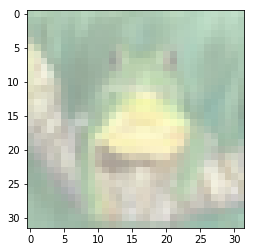

In [53]:
imshow(torchvision.utils.make_grid(images))

In [23]:
densenet = models.densenet161()